# Analyze long-slit spectrum

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__main__ = 'EasyFit'
__author__ = 'Pascal Louis <plouis35@gmail.com>'
__version__ = '1.2'
__keywords__ = ['astronomy', 'spectroscopy', 'astropy', 'specutils', 'specreduce', 'matplotlib']


## Imports libs

In [3]:
### matplotlib settings
import matplotlib.pyplot as plt

%config InlineBackend.rc = {}
plt.style.use(['dark_background'])
plt.rcParams.update({'figure.max_open_warning': 0}) 

### set the mpl backend
#%matplotlib widget
%matplotlib widget

import warnings, fnmatch, os
from time import gmtime, strftime
from pathlib import Path

import numpy as np

from astropy.table import Table, QTable
from astropy import units as u
from astropy.nddata import CCDData, StdDevUncertainty
from astropy.stats import mad_std
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning

from ccdproc import Combiner, combine, subtract_bias, subtract_dark, flat_correct
from ccdproc import trim_image, Combiner, ccd_process, cosmicray_median

from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import median_smooth, gaussian_smooth
from specutils.manipulation import extract_region, gaussian_smooth, convolution_smooth, median_smooth

warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', UserWarning)


## Define target

In [4]:
### science target
CAPTURE_DIR='../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/'
TARGET = 'ngc4151'


## Create logger

In [5]:
import sys
import logging

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')

## Analyse spectrum

### Load spectrum

In [6]:
with fits.open(CAPTURE_DIR + TARGET + '-1D-final-tabular.fit', overwrite=True, format='tabular-fits') as spc:
    specdata = spc[1].data
    header = spc[1].header
    final_spec = Spectrum1D(flux = specdata['flux']* u.mJy, spectral_axis = specdata['wavelength'] * u.AA)

final_spec

<Spectrum1D(flux=[1.8610481549210312 ... 0.5171235985500259] mJy (shape=(809,), mean=1.35952 mJy); spectral_axis=<SpectralAxis [4236.01352134 4239.38497059 4242.75676287 ... 7064.68290812 7068.33083262
 7071.97910014] Angstrom> (length=809))>

### Show known lines

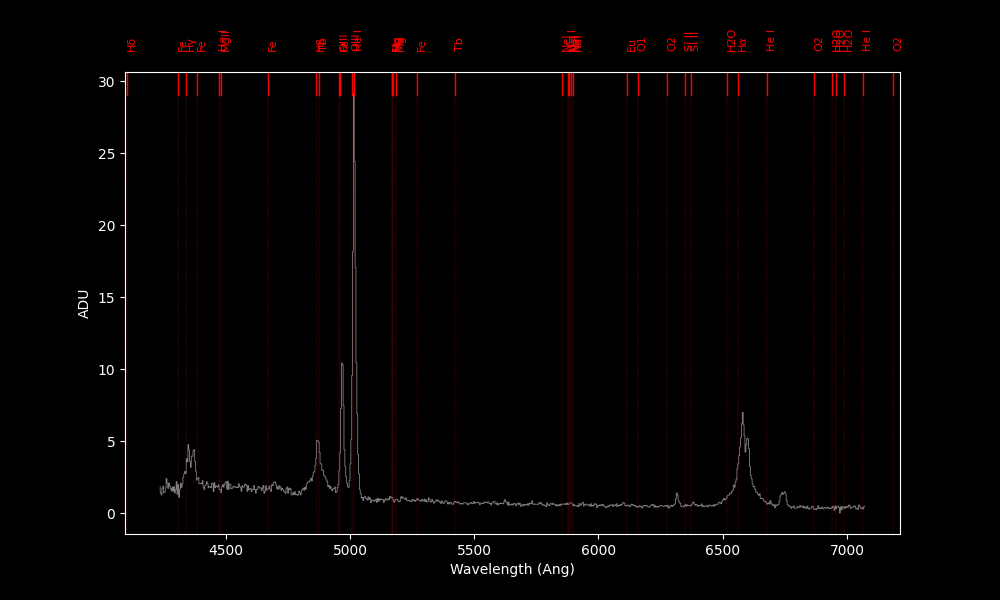

In [7]:
from spec_utils import show_lines
plt.figure(figsize = (10,6))
plt.step(final_spec.wavelength, final_spec.flux, color='grey', linewidth = '0.6') #, where="mid")
plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
#plt.ylim(-10000, 1e6)

show_lines(ax = None, show_line = True)


### Measure SNR

In [8]:
from specutils.fitting import fit_generic_continuum, fit_continuum
from specutils import SpectralRegion
from astropy.modeling import models, fitting
from specutils.analysis import snr, snr_derived
from specutils import Spectrum1D
from specutils.spectra import SpectralRegion
from specutils.manipulation import extract_region

#with fits.open(CAPTURE_DIR + TARGET + '-1D-final.fit') as file:
#    specdata = file[1].data
 #   header = file[1].header
  #  final_spec1d = Spectrum1D(flux = specdata['flux'] * u.mJy, spectral_axis = specdata['wavelength'] * u.AA)

print(f'snr = {snr_derived(final_spec)}')

snr = 8.270551390506267


### Remove continuum

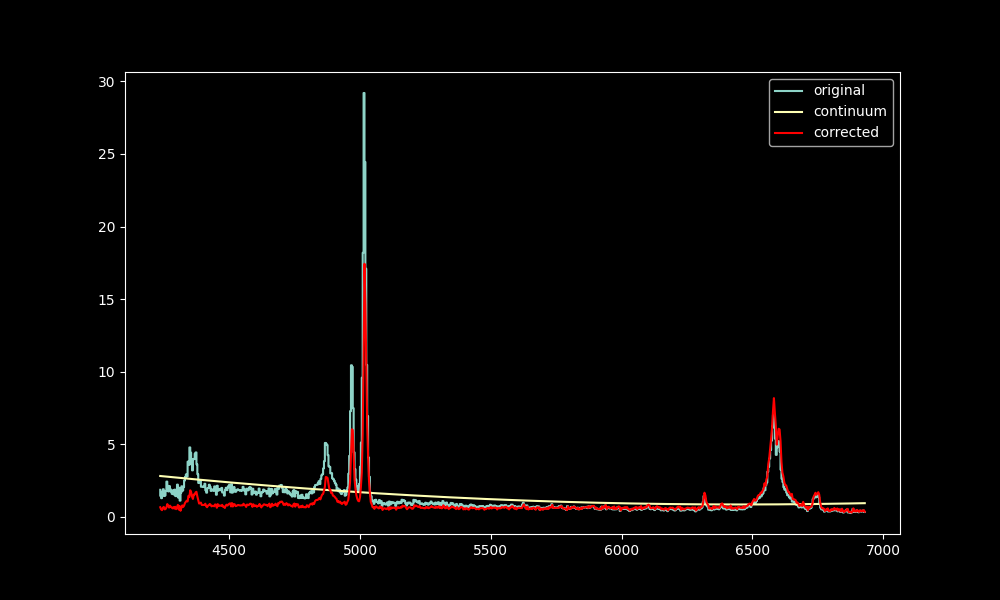

In [9]:
### extract continuum on a selected region

region = SpectralRegion(3800*u.AA, 6930*u.AA)     # low resolution
#region = SpectralRegion(6450*u.AA, 6750*u.AA)     # high resolution


sub_spectra = extract_region(final_spec, region)

#generic_continuum = fit_generic_continuum(sub_spectra, exclude_regions = [
        #SpectralRegion(3700 * u.AA, 4000 * u.AA),
         #SpectralRegion(4825 * u.AA, 4885 * u.AA),
         #SpectralRegion(4825 * u.AA, 5200 * u.AA),
         #SpectralRegion(6400 * u.AA, 6800 * u.AA)
        #])
generic_continuum = fit_continuum(sub_spectra, models.Chebyshev1D (degree=2) ) #Chebyshev1D (3)) #   Hermite1D(3))

generic_continuum_evaluated = generic_continuum(sub_spectra.spectral_axis)

spec_normalized = (sub_spectra / generic_continuum_evaluated)

plt.figure(figsize = (10,6))
plt.step(sub_spectra.spectral_axis, sub_spectra.flux)
plt.plot(sub_spectra.spectral_axis, generic_continuum_evaluated)
plt.plot(spec_normalized.spectral_axis, spec_normalized.flux, color='red')
plt.legend(['original', 'continuum', 'corrected'], loc=('best'))
#plt.xlim(4700, 5000)



### Identify lines

In [10]:
### identify lines
from specutils.fitting import find_lines_derivative
from specutils.fitting import fit_lines

lines = find_lines_derivative(spec_normalized, flux_threshold=2)
print('\nemission: \n', lines[lines['line_type'] == 'emission']) 
print('\nabsorption: \n', lines[lines['line_type'] == 'absorption']) 



emission: 
    line_center    line_type line_center_index
     Angstrom                                
----------------- --------- -----------------
4869.004766330686  emission               186
4968.766318881355  emission               215
5017.030317827725  emission               229
6578.963653600133  emission               672
6600.580556722041  emission               678

absorption: 
 line_center line_type line_center_index
  Angstrom                             
----------- --------- -----------------


### Fit a line

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean             stddev     
                            Angstrom          Angstrom    
    ------------------ ----------------- -----------------
    15.593469875546282 5018.705006184025 6.704769117193503


(4966.0, 5066.0)

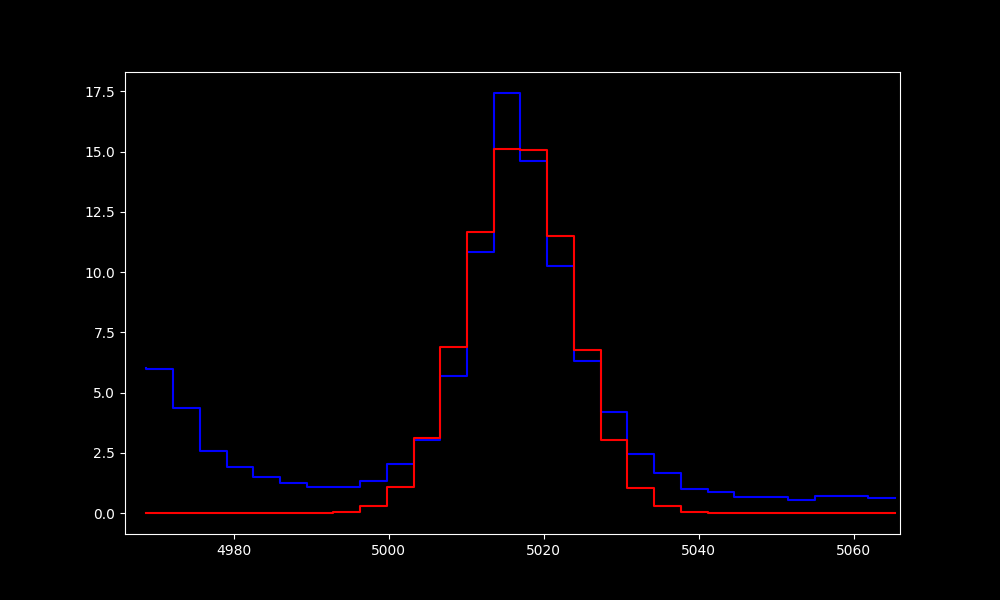

In [11]:
from specutils.manipulation import extract_region
from specutils.fitting import estimate_line_parameters
from specutils.analysis import centroid, fwhm
from specutils.fitting import fit_lines

lineAA = 5016
#lineAA = 6563
#lineAA = 4861

sr =  SpectralRegion((lineAA-50)*u.AA, (lineAA+50)*u.AA)
#sr =  SpectralRegion((lineAA-50)*u.AA, (lineAA+50)*u.AA)

#create a new spectrum of the selected region for plot
sub_spectrum = extract_region(spec_normalized, sr)
a_line = Spectrum1D(flux = sub_spectrum.flux, spectral_axis = sub_spectrum.spectral_axis)

line_estimate = models.Gaussian1D(mean = lineAA*u.AA, stddev = 5*u.AA, amplitude=4500)
line_model = fit_lines(sub_spectrum, line_estimate)
evaluated_model = line_model(sub_spectrum.wavelength)

print(line_model)

plt.figure(figsize = (10,6))
#plt.step(reg_spectra.wavelength, reg_spectra.flux, label="Original spectrum")
plt.step(a_line.spectral_axis, a_line.flux , label="original spectrum", color = 'b')
plt.step(a_line.spectral_axis, evaluated_model , label="Fit result", color = 'r')
#plt.plot(a_line.spectral_axis, a_line.flux)
plt.xlim(lineAA-50, lineAA+50)


### Measure line

In [12]:
### measure 
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import gaussian_sigma_width, gaussian_fwhm, fwhm, fwzi


print(f'gaussian fwhm = {gaussian_fwhm(a_line)}' )
center = centroid(a_line, sr)  
print(f'center = {center}')

print(f'fwhm = {fwhm(a_line)}') 
print(f'R = {(center / fwhm(a_line))}')
#print(f'fwzi = {fwzi(a_line)}') 

print(f'line flux = {line_flux(a_line)}'  )

#noisy_gaussian_with_continuum = noisy_gaussian + 1*u.Jy
print(f'equivalent width = {equivalent_width(a_line)}')


gaussian fwhm = 50.72535433650456 Angstrom
center = 5011.060952857144 Angstrom
fwhm = 13.10929746043439 Angstrom
R = 382.2524409093008
line flux = 384.3774335820816 Angstrom
equivalent width = -284.33237385048676 Angstrom
